#### [00] Importing Data

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks 
from imblearn.under_sampling import EditedNearestNeighbours 

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE 

**!! Edit kdPIC parameter**

specify the "kdPIC" and the band that would be calculated

In [2]:

from omegaconf import DictConfig,OmegaConf
conf = OmegaConf.load('config/config.yaml')
kdPIC=conf['config']['pic_']

#### [01] Under dan Over Sampling Function Definition

In [67]:
standard_=['B1_p15','B2_p15','B3_p15','B4_p15','B5_p15','B6_p15','B7_p15',
          'B8_p15','B8A_p15','B11_p15','B12_p15','NDVI_p50','NDWI_p50','NDBI_p50','SAVI_p50',
          'EVI_p50','GNDVI_p50']

def ratio_multiplier(y):
    from collections import Counter

    multiplier = strategy_under2
    target_stats = Counter(y)
    for key, value in target_stats.items():
        if key in multiplier:
            target_stats[key] = int(value * multiplier[key])
    return target_stats

def finalise(X,y):
    res = X.copy()
    res['nama_valid'] = y
    return res

def create_dataset(name_file):
    global df_sample
    global X_res_tl_s
    
    gs_folder = "gs://bps-gcp-bucket/MLST2023/preprocessing/"
    df_sample = pd.read_csv(gs_folder+name_file)
    
    y = df_sample.nama_valid
    X = df_sample[['B1_p15', 'B2_p15', 'B3_p15',
           'B4_p15', 'B5_p15', 'B6_p15', 'B7_p15', 'B8_p15', 'B8A_p15', 'B11_p15',
           'B12_p15', 'NDVI_p50', 'NDWI_p50', 'NDBI_p50', 'SAVI_p50', 'EVI_p50',
           'GNDVI_p50']]

    n = df_sample.groupby("nama_valid").nama_valid.count()
    ntmp = y.value_counts().median()
    nmean=int(0.8*ntmp)
    
    up_=n[n>int(1.3*nmean)]
    under_=n[n<int(0.7*nmean)]
    another_=n[(n<=int(1.3*nmean))&(n>=int(0.7*nmean))]
    
    strategy_upper = dict(zip(under_.index, [int(0.7*nmean)]*len(under_)))
    strategy_under = dict(zip(up_.index, [int(1.3*nmean)]*len(up_)))
    strategy_ = dict(zip(another_.index, another_))
       
    tl_ = TomekLinks('majority')
    enn_ = EditedNearestNeighbours('majority')
    rus_ = RandomUnderSampler(sampling_strategy=strategy_under)

    X_tl, y_tl = tl_.fit_resample(X, y)
    X_enn, y_enn = enn_.fit_resample(X, y)

    X_res_tl, y_res_tl = rus_.fit_resample(X_tl, y_tl)
    X_res_enn, y_res_enn = rus_.fit_resample(X_enn, y_enn)

    smote_ = SMOTE(sampling_strategy=strategy_upper)
    B_smote_ = BorderlineSMOTE(sampling_strategy=strategy_upper)

    X_res_tl_s, y_res_tl_s = smote_.fit_resample(X_res_tl, y_res_tl)
    X_res_enn_s, y_res_enn_s = smote_.fit_resample(X_res_enn, y_res_enn)

    X_res_tl_bs, y_res_tl_bs = B_smote_.fit_resample(X_res_tl, y_res_tl)
    X_res_enn_bs, y_res_enn_bs = B_smote_.fit_resample(X_res_enn, y_res_enn)
  
    finalise(X_res_tl_s, y_res_tl_s).to_csv(gs_folder+name_file[:-4]+"_tl_smote.csv", index=False)
    finalise(X_res_tl_bs, y_res_tl_bs).to_csv(gs_folder+name_file[:-4]+"_tl_border_smote.csv", index=False)
    finalise(X_res_enn_s, y_res_enn_s).to_csv(gs_folder+name_file[:-4]+"_enn_smote.csv", index=False)
    finalise(X_res_enn_bs, y_res_enn_bs).to_csv(gs_folder+name_file[:-4]+"_enn_border_smote.csv", index=False)
    
    df_sample['ket'] = 'asli'
    X_res_tl_s['ket'] = 'sintetik'
    X_res_tl_s['nama_valid'] = y_res_tl_s

#### [02] Running Under dan Over Sampling

In [68]:
name_file = ["sample_"+kdPIC+".csv",
             "sample_"+kdPIC+"_no_outlier.csv"]
for i in name_file: 
    create_dataset(i)
    if(i == name_file[0]):
        df_all = df_sample
        df_all = df_all.append(X_res_tl_s)
    else:
        df_all_no_outlier = df_sample
        df_all_no_outlier = df_all_no_outlier.append(X_res_tl_s)
    

/home/jupyter-peta_admin/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
/tmp/ipykernel_5149/3542957802.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(X_res_tl_s)
/home/jupyter-peta_admin/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
/tmp/ipykernel_5149/3542957802.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_no_outlier = df_all_no_outlier.append(X_res_tl_s)


#### [03] Perbandingan Jumlah Landmark per Kategori

**Data dengan Outlier**

In [82]:
pd.pivot_table(df_all, values='B1_p15', index='nama_valid', columns='ket',
               aggfunc='count')

ket,asli,sintetik
nama_valid,,
100101,38479,1652
100102,7157,1652
100107,3791,1652
100108,8690,1652
100201,1971,1652
100202,621,889
100203,1207,1207
100204,480,889
100205,17126,1652


[]

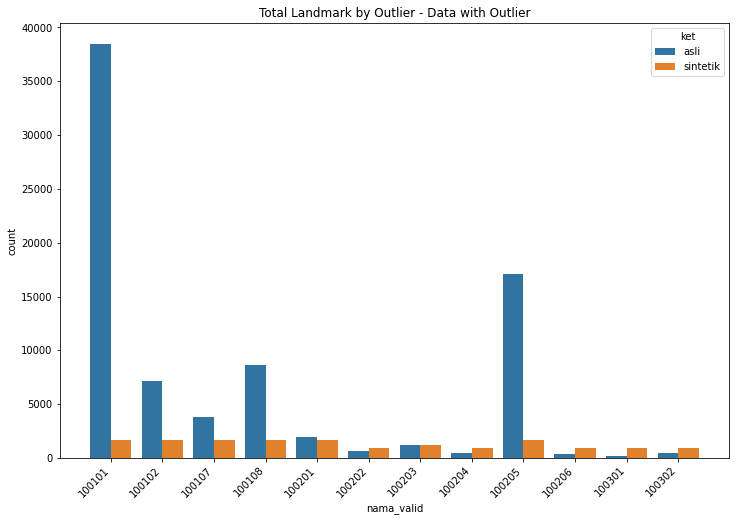

In [88]:
plt.figure(figsize=(12, 8))
sns.countplot(x='nama_valid',hue='ket',data=df_all)
plt.title("Total Landmark by Outlier - Data with Outlier")
plt.xticks(rotation=45, ha='right')
plt.savefig('ml_output/03_over_and_under_sampling/count_plot_oversampling_w_outlier.png')
plt.plot()

**Data tanpa Outlier**

In [83]:
pd.pivot_table(df_all_no_outlier, values='B1_p15', index='nama_valid', columns='ket',
               aggfunc='count')

ket,asli,sintetik
nama_valid,,
100101,35302,1475
100102,6571,1475
100107,3365,1475
100108,7605,1475
100201,1773,1475
100202,528,794
100203,1066,1066
100204,406,794
100205,15255,1475


[]

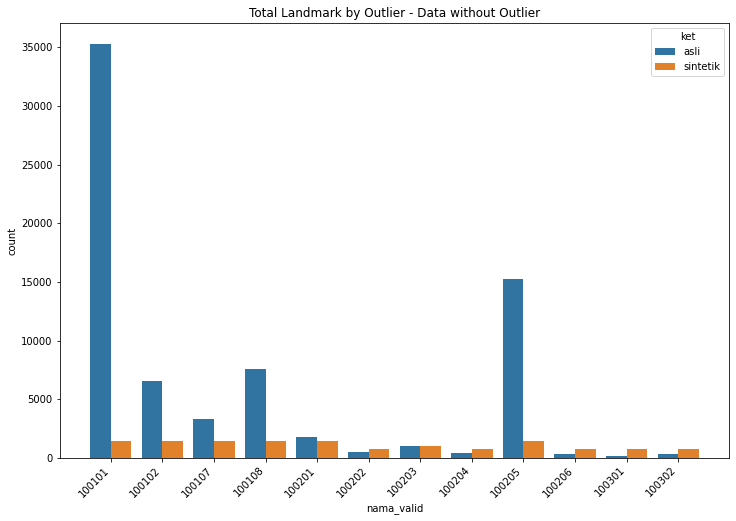

In [87]:
plt.figure(figsize=(12, 8))
sns.countplot(x='nama_valid',hue='ket',data=df_all_no_outlier)
plt.title("Total Landmark by Outlier - Data without Outlier")
plt.xticks(rotation=45, ha='right')
plt.savefig('ml_output/03_over_and_under_sampling/count_plot_oversampling_wo_outlier.png')
plt.plot()